In [110]:
!pip install sseclient mmh3 bitarray

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, LongType
spark = SparkSession.builder \
    .appName("WikipediaBotFilter") \
    .getOrCreate()

In [3]:
import zipfile
import os

def unzip_archive(archive_path, extract_dir):
    """
    Unzips the specified archive into the given directory.

    :param archive_path: Path to the ZIP archive.
    :param extract_dir: Directory where files will be extracted.
    """
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted all files to {extract_dir}")

# Example Usage
archive_path = '/content/sample_data.zip'        # Replace with your ZIP file path
extract_dir = '/content/extracted_csvs_new'          # Replace with your desired extraction path

unzip_archive(archive_path, extract_dir)


Extracted all files to /content/extracted_csvs_new


In [130]:
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType, BooleanType, LongType

schema = StructType([
    StructField("id", LongType(), True),
    StructField("title", StringType(), True),
    StructField("user", StringType(), True),
    StructField("bot", BooleanType(), True),
    StructField("length", IntegerType(), True),
    StructField("wiki", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("minor", BooleanType(), True),
    StructField("comment", StringType(), True),
])

df = spark.read.csv(
    path="/content/extracted_csvs_new/sample_data/*.csv",
    header=True,
    schema = schema
)

df.printSchema()
df.show(5)

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user: string (nullable = true)
 |-- bot: boolean (nullable = true)
 |-- length: integer (nullable = true)
 |-- wiki: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minor: boolean (nullable = true)
 |-- comment: string (nullable = true)

+----------+--------------------+--------------+-----+------+------+-------------------+-----+--------------------+
|        id|               title|          user|  bot|length|  wiki|          timestamp|minor|             comment|
+----------+--------------------+--------------+-----+------+------+-------------------+-----+--------------------+
|1833392304|1981 Golbaf earth...|Dawnseeker2000|false|   -27|enwiki|2024-10-27 02:55:48| true|[[WP:AWB/T|Typo f...|
|1833392603|     Lebanese Arabic| 70.83.137.110|false|    -8|enwiki|2024-10-27 02:56:21|false|                NULL|
|1833392715|The Galway Races ...|JJMC89 bot III| true|    12|enwiki|2024-10-27 0

In [34]:
bot_df = df.filter(col("bot") == True)

In [35]:
human_df = df.filter(col("bot") == False)

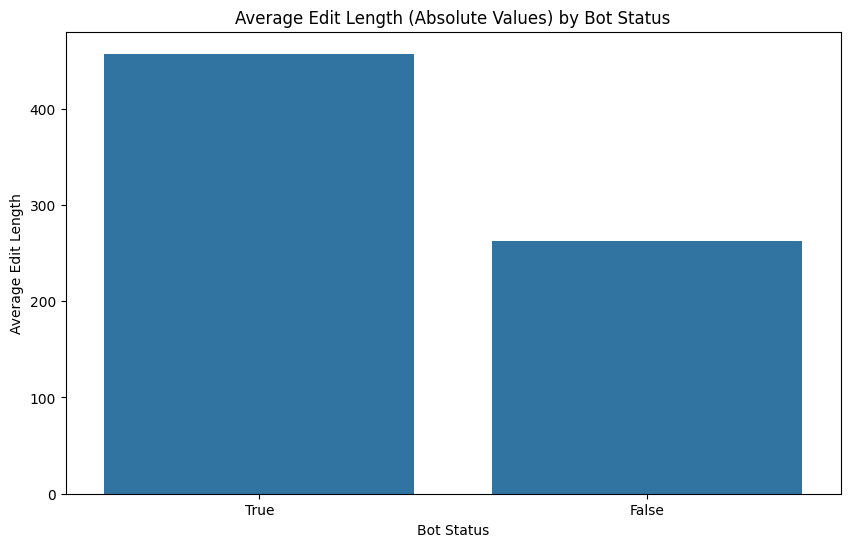

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, to_timestamp, avg, abs

# Create SparkSession
spark = SparkSession.builder.appName("WikipediaEdits").getOrCreate()

# Convert timestamp to PySpark timestamp type
df = df.withColumn("timestamp", to_timestamp("timestamp"))

# Handle None values
df = df.fillna({"length": 0, "bot": False})  # Replace None in numeric and boolean columns

# Use absolute values for length
df = df.withColumn("length", abs(col("length")))

# Group by `bot` and calculate average length
avg_length_df = df.groupBy("bot").agg(avg("length").alias("avg_length"))

# Convert Spark DataFrame to Pandas DataFrame for visualization
avg_length_pandas_df = avg_length_df.toPandas()

# Ensure categorical consistency
avg_length_pandas_df["bot"] = avg_length_pandas_df["bot"].astype(str)

# Bar Chart Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_length_pandas_df, x="bot", y="avg_length")
plt.title("Average Edit Length (Absolute Values) by Bot Status")
plt.xlabel("Bot Status")
plt.ylabel("Average Edit Length")
plt.show()


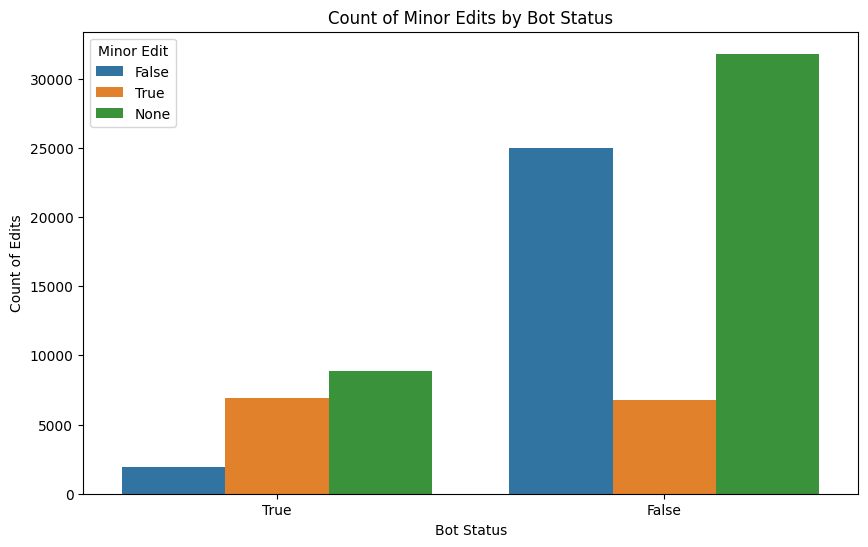

In [133]:
# Count occurrences of `minor` for each `bot` class
minor_counts_df = df.groupBy("bot", "minor").agg(count("*").alias("count"))

# Convert Spark DataFrame to Pandas DataFrame for visualization
minor_counts_pandas_df = minor_counts_df.toPandas()

# Ensure categorical consistency
minor_counts_pandas_df["bot"] = minor_counts_pandas_df["bot"].astype(str)
minor_counts_pandas_df["minor"] = minor_counts_pandas_df["minor"].astype(str)

# Bar Chart Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=minor_counts_pandas_df, x="bot", y="count", hue="minor")
plt.title("Count of Minor Edits by Bot Status")
plt.xlabel("Bot Status")
plt.ylabel("Count of Edits")
plt.legend(title="Minor Edit")
plt.show()

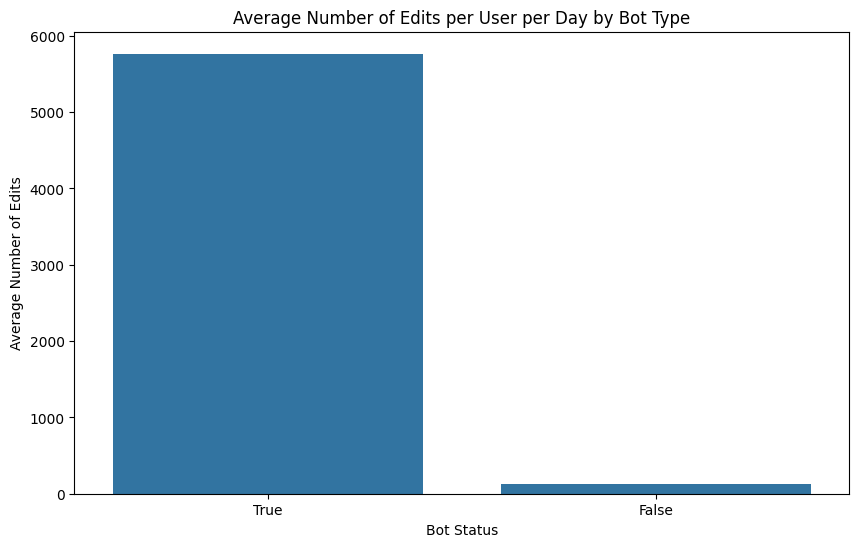

In [134]:
df = df.withColumn("date", to_date("timestamp"))

# Calculate the number of edits for each user on a specific date
user_date_edits = df.groupBy("user", "date").agg(count("*").alias("user_edits"))

# Join back to the original DataFrame to add the number of edits per user per date
df = df.join(user_date_edits, on=["user", "date"])

# Group by bot type and calculate the average number of edits
avg_edits_by_bot = df.groupBy("bot").agg(avg("user_edits").alias("avg_user_edits"))

# Convert to Pandas for plotting
avg_edits_by_bot_pandas = avg_edits_by_bot.toPandas()

# Ensure bot is a string for plotting
avg_edits_by_bot_pandas["bot"] = avg_edits_by_bot_pandas["bot"].astype(str)

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_edits_by_bot_pandas, x="bot", y="avg_user_edits")
plt.title("Average Number of Edits per User per Day by Bot Type")
plt.xlabel("Bot Status")
plt.ylabel("Average Number of Edits")
plt.show()

Top 20 words in bot comments:
+--------------------+-----+
|                word|count|
+--------------------+-----+
|                task|10243|
|                  20|10152|
|                user| 6163|
|                 log| 5879|
|           templates| 5711|
|           wikipedia| 5527|
|                with| 5257|
|                 see| 5130|
|                lang| 5093|
|            replaced| 5072|
|   2024_september_27| 5068|
|                 tfd| 5068|
|          _templates| 5068|
|replace_and_delet...| 5068|
|             monkbot| 5068|
|               langx| 5068|
|             replace| 5068|
|templates_for_dis...| 5068|
|                   1| 4321|
|                 bot| 1510|
+--------------------+-----+
only showing top 20 rows


Top 20 words in human comments:
+-----------+-----+
|       word|count|
+-----------+-----+
|         wp| 4473|
|         to| 2781|
|       talk| 2128|
|      added| 1931|
|        the| 1908|
|         of| 1820|
|         by| 1758|
|        and| 1

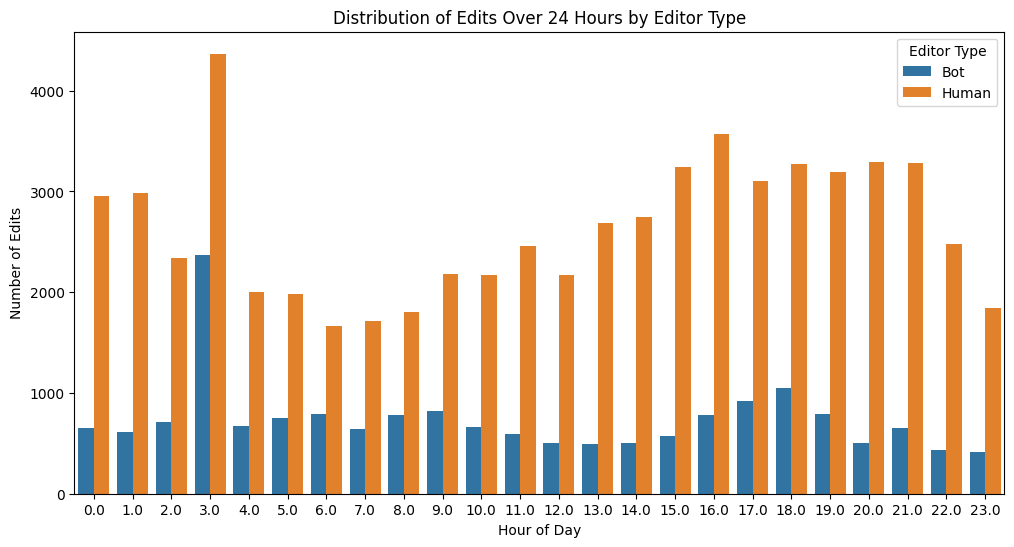

In [5]:
from pyspark.sql.functions import col, lower, explode, split, regexp_replace, hour, when, count

df = df.withColumn('comment', col('comment').cast('string'))
df = df.withColumn('user', col('user').cast('string'))

# Convert 'timestamp' to timestamp type
df = df.withColumn('timestamp', (col('timestamp')).cast('timestamp'))

# Separate bot and human edits using the 'bot' field
bot_edits = df.filter(col('bot') == True)
human_edits = df.filter(col('bot') == False)

# Text Preprocessing Function (UDF)
from pyspark.sql.functions import udf

stop_words = ['і', 'в', 'на', 'до', 'з', 'що', 'не', 'це']

def preprocess_text(text):
    import re
    text = text.lower()
    words = re.findall(r'\b\w+\b', text, re.UNICODE)
    words = [word for word in words if word not in stop_words]
    return words

preprocess_text_udf = udf(preprocess_text, ArrayType(StringType()))

# Preprocess comments and collect words for bots
bot_comments = bot_edits.select('comment').na.drop()
bot_comments = bot_comments.withColumn('words', preprocess_text_udf(col('comment')))
bot_words = bot_comments.select(explode(col('words')).alias('word'))
bot_word_counts = bot_words.groupBy('word').count().orderBy(col('count').desc())

# Preprocess comments and collect words for humans
human_comments = human_edits.select('comment').na.drop()
human_comments = human_comments.withColumn('words', preprocess_text_udf(col('comment')))
human_words = human_comments.select(explode(col('words')).alias('word'))
human_word_counts = human_words.groupBy('word').count().orderBy(col('count').desc())

print("Top 20 words in bot comments:")
bot_word_counts.show(20)

# Display top 20 words for humans
print("\nTop 20 words in human comments:")
human_word_counts.show(20)


In [103]:
import math
from bitarray import bitarray
import mmh3

class BloomFilter:
    def __init__(self, expected_items, false_positive_rate):
        """
        Initialize the Bloom filter with a given expected number of items and false positive rate.
        """
        self.expected_items = expected_items
        self.false_positive_rate = false_positive_rate
        self.size = self._calculate_size()
        self.hash_count = self._calculate_hash_count()
        self.bit_array = bitarray(self.size)
        self.bit_array.setall(0)

    def _calculate_size(self):
        """
        Calculate the size of the bit array (m) using the formula:
        m = -(n * log(p)) / (log(2)^2)
        """
        n = self.expected_items
        p = self.false_positive_rate
        return math.ceil(-(n * math.log(p)) / (math.log(2) ** 2))

    def _calculate_hash_count(self):
        """
        Calculate the optimal number of hash functions (k) using the formula:
        k = (m / n) * log(2)
        """
        m = self.size
        n = self.expected_items
        return math.ceil((m / n) * math.log(2))

    def add(self, item):
        """
        Add an item to the Bloom filter by hashing it with each hash function and setting the corresponding bits.
        """
        for i in range(self.hash_count):
            index = mmh3.hash(item, i) % self.size
            self.bit_array[index] = True

    def contains(self, item):
        """
        Check if an item is in the Bloom filter.
        Returns True if the item might be in the set, False if it is definitely not in the set.
        """
        for i in range(self.hash_count):
            index = mmh3.hash(item, i) % self.size
            if not self.bit_array[index]:
                return False
        return True

    def get_state(self):
        """
        Serialize the Bloom filter's state for distribution or saving.
        """
        return {
            'size': self.size,
            'hash_count': self.hash_count,
            'bit_array': self.bit_array.tobytes()
        }

    @classmethod
    def from_state(cls, state):
        """
        Deserialize a Bloom filter from a serialized state.
        """
        obj = cls(expected_items=1, false_positive_rate=0.1)  # Placeholder values
        obj.size = state['size']
        obj.hash_count = state['hash_count']
        obj.bit_array = bitarray()
        obj.bit_array.frombytes(state['bit_array'])
        return obj


In [ ]:
bot_df = df.filter(col('bot') == True)

# DataFrame with human edits
human_df = df.filter(col('bot') == False)

In [87]:
unique_bot_usernames_df = bot_df.select('user').distinct().collect()

In [96]:
len(df.select('user').distinct().collect())

10025

In [95]:
# Count of unique bot usernames
unique_bot_usernames_count = bot_df.select('user').distinct().count()

print(f"Number of unique bot usernames: {unique_bot_usernames_count}")


Number of unique bot usernames: 86


In [107]:
# Initialize Bloom Filter
bf = BloomFilter(unique_bot_usernames_count, 0.1)

for username in unique_bot_usernames_df:
    bf.add(username['user'])

In [108]:
bf_state = bf.get_state()

# Broadcast the internal state
bf_state_broadcast = spark.sparkContext.broadcast(bf_state)

# Define the UDF
def is_bot():
    bf_local = None
    def inner(username):
        nonlocal bf_local
        if bf_local is None:
            # Reconstruct the Bloom filter
            bf_state = bf_state_broadcast.value
            bf_local = BloomFilter.from_state(bf_state)
        return bf_local.contains(username)
    return inner

is_bot_udf = udf(is_bot(), BooleanType())

# Extract unique usernames with their 'bot' label
unique_users_df = df.select('user', 'bot').distinct()

# Apply the UDF to get predictions
unique_users_df = unique_users_df.withColumn('predicted_bot', is_bot_udf(col('user')))

# Evaluate predictions
unique_users_df = unique_users_df.withColumn('correct_prediction', col('predicted_bot') == col('bot'))

correct_predictions_count = unique_users_df.filter(col('correct_prediction') == True).count()
total_users = unique_users_df.count()
accuracy = correct_predictions_count / total_users

print(f"Number of correctly predicted users: {correct_predictions_count}")
print(f"Total number of unique users: {total_users}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix components
true_positive = (col('predicted_bot') == True) & (col('bot') == True)
false_positive = (col('predicted_bot') == True) & (col('bot') == False)
true_negative = (col('predicted_bot') == False) & (col('bot') == False)
false_negative = (col('predicted_bot') == False) & (col('bot') == True)

tp = unique_users_df.filter(true_positive).count()
fp = unique_users_df.filter(false_positive).count()
tn = unique_users_df.filter(true_negative).count()
fn = unique_users_df.filter(false_negative).count()

print(f"True Positives (Bots correctly identified): {tp}")
print(f"False Positives (Humans incorrectly identified as bots): {fp}")
print(f"True Negatives (Humans correctly identified): {tn}")
print(f"False Negatives (Bots missed): {fn}")

# Calculate Precision and Recall
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Number of correctly predicted users: 8945
Total number of unique users: 10033
Accuracy: 89.16%
True Positives (Bots correctly identified): 86
False Positives (Humans incorrectly identified as bots): 1087
True Negatives (Humans correctly identified): 8859
False Negatives (Bots missed): 0
Precision: 7.33%
Recall: 100.00%


Possible Features?

In [ ]:
from pyspark.sql.functions import log, log10, col
df = df.withColumn("log_length", log(col("length")))


In [ ]:
from pyspark.sql.functions import length

df = df.withColumn("comment_length", length(col("comment")))


In [ ]:
from pyspark.sql.functions import col

df = df.withColumn(
    "is_bot_comment",
    (
        col("comment").startswith("Tagging") |
        col("comment").startswith("updating") |
        col("comment").startswith("moving") |
        col("comment").startswith("update") |
        col("comment").startswith("next queue") |
        col("comment").startswith("added") |
        col("comment").startswith("copying") |
        col("comment").startswith("[[User:")
    )
)
